# Universal Mixtures


<!-- 
In this example, we are going to perform an exact inference for a coin toss model that can be represented as:

$$
\begin{equation}
\begin{aligned}
p(\theta) &= \mathrm{Beta}(\theta|a, b),\\
p(y_i|\theta) &= \mathrm{Ber}(y_i|\theta),\\
\end{aligned}
\end{equation}
$$

where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of Bernoulli.
We are interested in inferring the posterior distribution of $\theta$.

We start with importing all needed packages: -->

In [1]:
using Revise

In [2]:
using RxInfer, Distributions, Random, Plots

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1664


John and Jane are having a coin toss competition. Before they start, they both have the feeling that something is not right. The coin is unbalanced and favors one side over the other. However, both John and Jane do not know which side is being favored. John thinks that the coin favors heads and Jane thinks tails. Coincidentally, both John and Jane have a strong mathematics background and express their gut feeling in terms of a prior distribution over the coin parameter $\theta$, which represents the probability of the coin landing on heads. Based on their gut feeling and the support of $\theta\in[0,1]$ they come up with the prior beliefs:

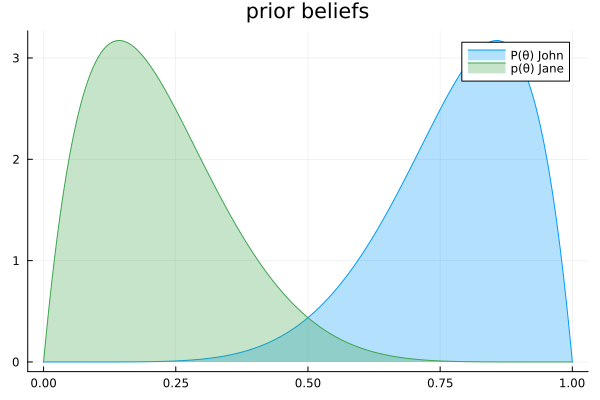

In [3]:
rθ = range(0, 1, length = 1000)
p = plot(title = "prior beliefs")
plot!(rθ, (x) -> pdf(Beta(7.0, 2.0), x), fillalpha=0.3, fillrange = 0, label="P(θ) John", c=1)
plot!(rθ, (x) -> pdf(Beta(2.0, 7.0), x), fillalpha=0.3, fillrange = 0, label="p(θ) Jane", c=3,)

John and Jane really want to clear the odds and decide to perform a lengthy experiment. They toss the unbalanced coin 50 times, because their favorite TV show is cancelled anyway and therefore they have plenty of time. 

In [4]:
true_coin = Bernoulli(0.25)
nr_throws = 5
dataset = Int.(rand(MersenneTwister(42), true_coin, nr_throws))
nr_heads, nr_tails = sum(dataset), nr_throws-sum(dataset)
println("experimental outcome: \n - heads: ", nr_heads, "\n - tails: ", nr_tails);

experimental outcome: 
 - heads: 2
 - tails: 3


For updating their prior beliefs about the parameter $\theta$, they will perform probabilistic inference in the model based on Bayes' rule. Luckily everything is tractable and therefore they can resort to exact inference. They decide to outsource these tedious computations using `ReactiveMP.jl` and specify the following models:

In [5]:
@model function beta_model_john(nr_throws)

    # specify experimental outcomes
    y = datavar(Int64, nr_throws)

    # specify John's prior model over θ
    θ ~ Beta(7.0, 2.0)

    # create likelihood models
    for i in 1:nr_throws
        y[i] ~ Bernoulli(θ)
    end

    return y, θ
    
end

In [6]:
@model function beta_model_jane(nr_throws)

    # specify experimental outcomes
    y = datavar(Int64, nr_throws)

    # specify Jane's prior model over θ
    θ ~ Beta(2.0, 7.0)

    # create likelihood models
    for i in 1:nr_throws
        y[i] ~ Bernoulli(θ)
    end

    return y, θ
    
end

Now it is time to figure out whose prior belief was the best and who was actually right. They perform probabilistic inference automatically and compute the Bethe free energy to compare eachothers models.

In [16]:
result_john = inference(
    model = beta_model_john(nr_throws), 
    data  = (y = dataset, ),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (θ)
  Free Energy:     | Real[4.74416]


In [18]:
result_jane = inference(
    model = beta_model_jane(nr_throws), 
    data  = (y = dataset, ),
    free_energy = true
)

Inference results:
  Posteriors       | available for (θ)
  Free Energy:     | Real[3.93323]


From these results, they agree that Jane her gut feeling was right all along, as her Bethe free energy is lower. Nonetheless, after the 50 throws, they now have a better idea about the underlying $\theta$ parameter. They formulate this through the posterior distributions:

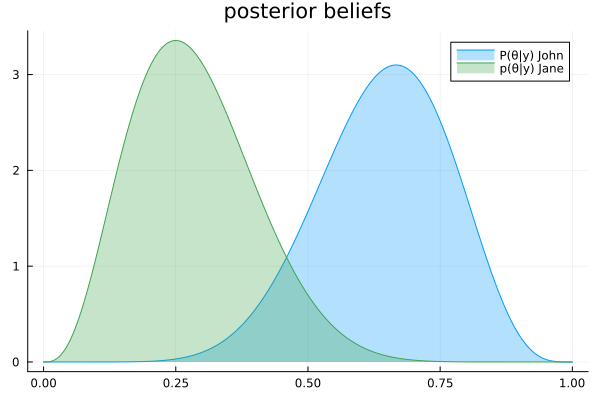

In [19]:
rθ = range(0, 1, length = 1000)
p = plot(title = "posterior beliefs")
plot!(rθ, (x) -> pdf(result_john.posteriors[:θ], x), fillalpha=0.3, fillrange = 0, label="P(θ|y) John", c=1)
plot!(rθ, (x) -> pdf(result_jane.posteriors[:θ], x), fillalpha=0.3, fillrange = 0, label="p(θ|y) Jane", c=3,)

What John and Jane did not know, was that Mary, their neighbour, was overhearing their conversation. She was also curious, but could not see the coin. She did not really know how to formulate a prior distribution over $\theta$, so instead she combined both John and Jane their prior beliefs. She had the feeling that John his assessment was more correct, as he was often going to the casino. As a result, she mixed the prior beliefs of John and Jane with proportions 0.7 and 0.3, respecively. Her prior distribution over $\theta$ now became

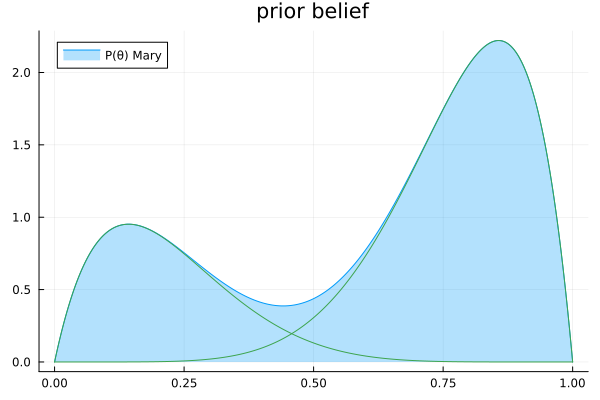

In [20]:
rθ = range(0, 1, length = 1000)
p = plot(title = "prior belief")
plot!(rθ, (x) -> pdf(MixtureModel([Beta(7.0, 2.0), Beta(2.0, 7.0)], Bernoulli(0.7)), x), fillalpha=0.3, fillrange = 0, label="P(θ) Mary", c=1)
plot!(rθ, (x) -> 0.7*pdf(Beta(7.0, 2.0), x), c=3, label="")
plot!(rθ, (x) -> 0.3*pdf(Beta(2.0, 7.0), x), c=3, label="")

She was also interested in the results and used the new `Switch` node and addons in `ReactiveMP.jl`. She specified her model as follows and performed inference in this model:

In [21]:
@model function beta_model_mary(nr_throws)

    # specify experimental outcomes
    y = datavar(Int64, nr_throws)

    # specify John's and Jane's prior models over θ
    θ_john ~ Beta(7.0, 2.0)
    θ_jane ~ Beta(2.0, 7.0)

    # specify initial guess as to who is right
    john_is_right ~ Bernoulli(0.7)

    # specify mixture prior Distribution
    θ ~ Switch(john_is_right, (θ_john, θ_jane))

    # create likelihood models
    for i in 1:nr_throws
        y[i] ~ Bernoulli(θ)
    end

    return y, θ
    
end

In [22]:
result_mary = inference(
    model = beta_model_mary(nr_throws), 
    data  = (y = dataset, ),
    returnvars = (θ = KeepLast(), θ_john = KeepLast(), θ_jane = KeepLast(), john_is_right = KeepLast()),
    options = ( addons = (AddonLogScale(), ), )
)

Inference results:
  Posteriors       | available for (john_is_right, θ_john, θ, θ_jane)


Mary was happy, with her mixture prior, she beat John in terms of performance. However, it was not the best decision to think that John was right. In fact, after the experiment there was only a 6% change remaining that John was right. Her posterior distribution over $\theta$ also changed, and as expected the estimate from Jane was more prominent.

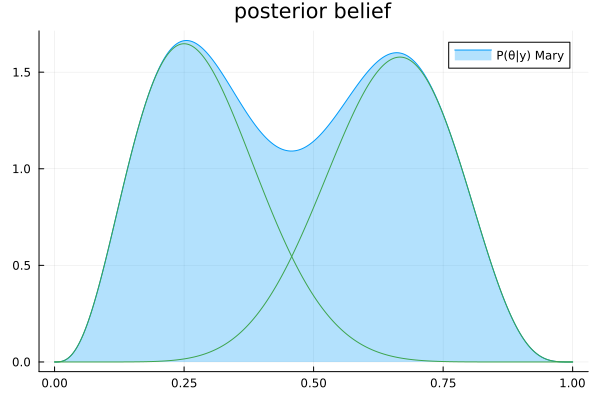

In [23]:
rθ = range(0, 1, length = 1000)
p = plot(title = "posterior belief")
plot!(rθ, (x) -> pdf(result_mary.posteriors[:θ], x), fillalpha=0.3, fillrange = 0, label="P(θ|y) Mary", c=1)
plot!(rθ, (x) -> probvec(result_mary.posteriors[:θ].prior)[1]*pdf(result_mary.posteriors[:θ].components[1], x), label="", c=3)
plot!(rθ, (x) -> probvec(result_mary.posteriors[:θ].prior)[2]*pdf(result_mary.posteriors[:θ].components[2], x), label="", c=3)